# Project-2 : Spam Detection Using TensorFlow(Python)

### 0. Import the project dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import string
from nltk.corpus import stopwords
import sklearn
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


### 1. Problem Statement
The Objective is to build a Machine Learning model to detect spam emails.
- Prepare the dataset for machine learning including data cleaning, removing missing values and splitting the data into training and test sets.
- Building a TensorFlow Model to detect spam emails.
- Evaluate the performance of the model on the test dataset
- Analyze the model coeffients to understand the importance of the different features.
- Build a report that descibes the steps you took to complete the task. the result of our analysis and conlcusions
- The code that i used to build also describe it.

### 2. Relevent Dataset

In [4]:
data = pd.read_csv("/content/spam_ham_dataset.csv")
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


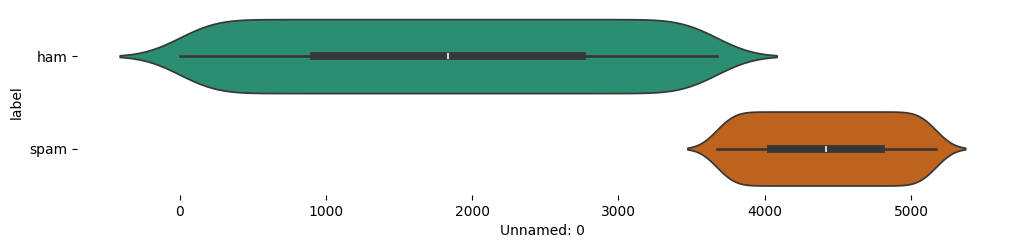

In [5]:
# @title label vs Unnamed: 0

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Unnamed: 0', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### 3. Data Exploration

#### Visualizing the data distribution

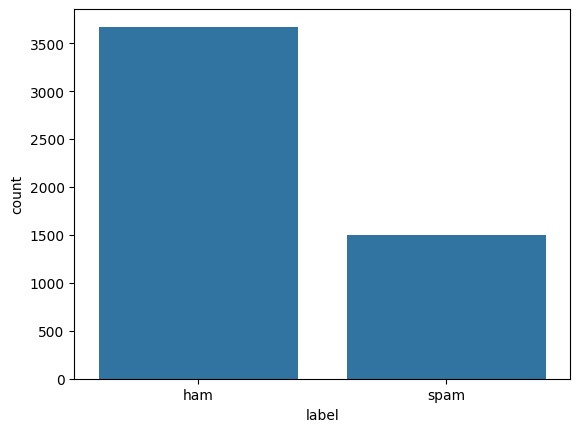

In [6]:
sns.countplot(x='label', data = data)
plt.show()

#### Dataset Balancing

In [7]:
email_msg = data[data.label_num == 0]
spam_msg = data[data.label_num == 1]
email_msg = email_msg.sample(n=len(spam_msg), random_state=42)

#### Let's Visualize the balanced dataset

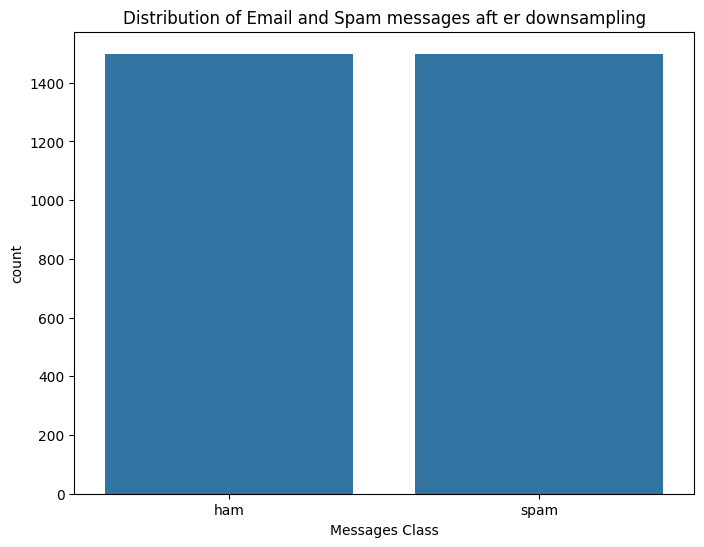

In [8]:
balanced_data = pd.concat([email_msg, spam_msg], ignore_index=True)
plt.figure(figsize=(8 , 6))
sns.countplot(data = balanced_data, x = 'label')
plt.title('Distribution of Email and Spam messages aft er downsampling')
plt.xlabel('Messages Class')
plt.show()

### 4. Data Preprocessing

#### Let's Preprocess the text dataset

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
punctuations_list = string.punctuation
def rem_punch(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text'] =  balanced_data['text'].apply(lambda x: rem_punch(x))

def rem_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)
    output = " ".join(imp_words)

    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: rem_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


#### Let's visualize the text dataset using wordcloud

In [11]:
def plot_words(data, typ):
    sms_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(
        background_color='black',
        max_words = 100,
        width = 800,
        height = 400,
        collocations = False
        ).generate(sms_corpus)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} email', fontsize=15)

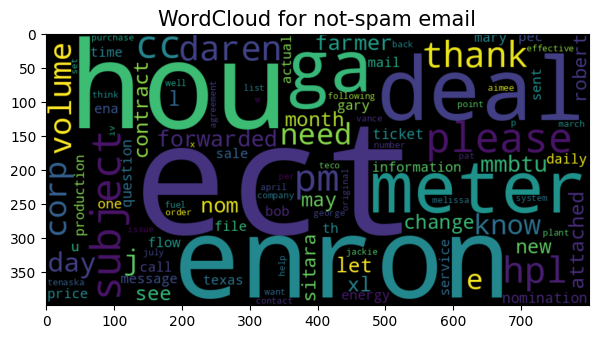

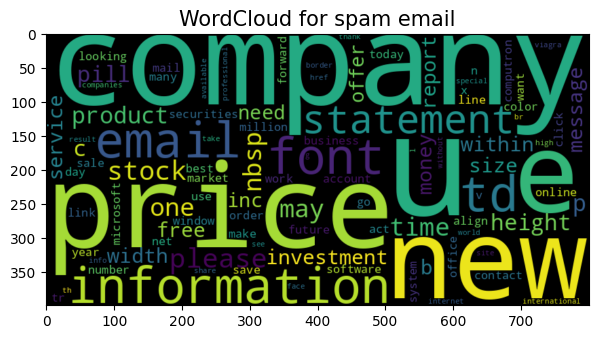

In [12]:
plot_words(balanced_data[balanced_data['label_num'] == 0], typ='not-spam')
plot_words(balanced_data[balanced_data['label_num'] == 1], typ='spam')


#### Let's split the dataset into train and test sets

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    balanced_data['text'],
    balanced_data['label_num'],
    test_size=0.2,
    random_state=42
)

#### Tokenization and Padding

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
max_len = 100

train_sequences = pad_sequences(train_sequences,
                                maxlen = max_len,
                                padding = 'post',
                                truncating = 'post')

test_sequences = pad_sequences(test_sequences,
                               maxlen = max_len,
                               padding='post',
                               truncating = 'post')

### 5. Machine Learning Model

In [15]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim=32, input_length=100))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1274912   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1278625 (4.88 MB)
Trainable params: 1278625 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics= ['accuracy']
              )

history = model.fit(train_sequences, Y_train, epochs=20, batch_size=32, validation_data=(test_sequences, Y_test))

Epoch 1/20
75/75 [==============================] - 16s 169ms/step - loss: 0.6910 - accuracy: 0.5334 - val_loss: 0.6818 - val_accuracy: 0.5883
Epoch 2/20
75/75 [==============================] - 10s 133ms/step - loss: 0.3089 - accuracy: 0.9012 - val_loss: 0.1548 - val_accuracy: 0.9617
Epoch 3/20
75/75 [==============================] - 8s 114ms/step - loss: 0.1284 - accuracy: 0.9708 - val_loss: 0.1615 - val_accuracy: 0.9617
Epoch 4/20
75/75 [==============================] - 7s 96ms/step - loss: 0.1063 - accuracy: 0.9771 - val_loss: 0.1412 - val_accuracy: 0.9683
Epoch 5/20
75/75 [==============================] - 7s 93ms/step - loss: 0.0984 - accuracy: 0.9791 - val_loss: 0.1929 - val_accuracy: 0.9567
Epoch 6/20
75/75 [==============================] - 5s 66ms/step - loss: 0.1029 - accuracy: 0.9783 - val_loss: 0.1803 - val_accuracy: 0.9467
Epoch 7/20
75/75 [==============================] - 5s 66ms/step - loss: 0.1177 - accuracy: 0.9700 - val_loss: 0.0837 - val_accuracy: 0.9800
Epoch 8/

### 6. Model Evaluation

In [17]:
test_loss, test_accuracy = model.evaluate(test_sequences, Y_test)
print("Test Loss :", test_loss)
print("Test Accuracy :", test_accuracy)

19/19 [==============================] - 0s 4ms/step - loss: 0.1301 - accuracy: 0.9767
Test Loss : 0.13006488978862762
Test Accuracy : 0.9766666889190674


#### Visualizing the model's test accuracy

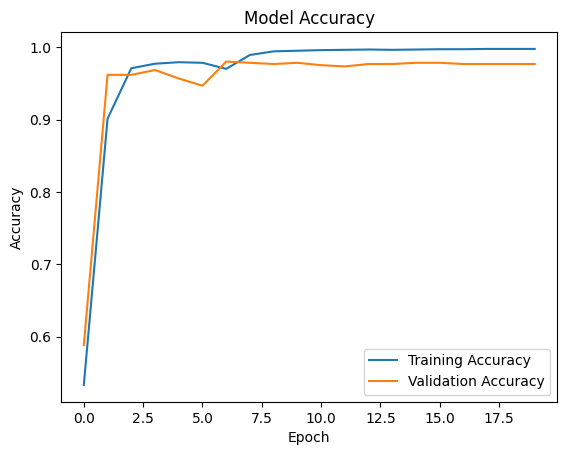

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### 7. Conclusion

Model Perform well on the training and test dataset with the loss and accuracy of 
1. Test Loss : 0.13006488978862762 
2. Test Accuracy : 0.9766666889190674